In [1]:
import sys
sys.path.append('..')
import os
import shutil

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

from data import *
from model import Loop
from utils import generate_merlin_wav

from torch.autograd import Variable
from IPython.display import Audio

import phonemizer
import spectrogram as sp
import torch
import copy

import pandas as pd

from scipy.io import wavfile

from IPython.display import display, HTML

import IPython.display

%load_ext autoreload
%autoreload 2

In [2]:
import evaluate_loss_func_for_notebook as el

In [3]:
os.chdir('/home/ubuntu/loop')
os.getcwd()

'/home/ubuntu/loop'

In [4]:
def map_original_npz_files(workings, data='data/vctk'):
    loader = el.get_loader(data_path=data)

    found = dict()

    for i, npz_file in enumerate(loader.dataset):
        this_file = loader.dataset.npzs[i]
        this_spkr = npz_file[2]
        matched = False

        #print this_file
        #print this_spkr
        for idx in np.nditer(np.where(workings['spkr'] == this_spkr)):
            #print 'iter' + str(idx)
            this_target_txt = workings['txt'][idx, :]
            idx_max = np.max(np.where(this_target_txt != 0))
            this_target_txt = this_target_txt[:idx_max+1]

            if np.array_equal(this_target_txt, npz_file[0].cpu().numpy()):
                #print 'match:' + str(idx)
                matched = True
                found[np.asscalar(idx)] = (i, this_file, this_spkr, this_target_txt)
                continue

        if not matched:
            print 'no match: ' + str(i)
            
    return found

In [5]:
def print_phonemes(loader, w):
    d = {b: a for a, b in loader.dataset.dict.iteritems()}
    print [d[x] for x in w] 

In [6]:
def plot_mgc_feature_comparison(feats_a, feats_b, label_a, label_b):
    # plot mgc features
    plt.figure(figsize=(20,20))
    for x in range(60):
        plt.subplot(10, 6, x+1)
        plt.plot(feats_a[:, x])
        plt.plot(feats_b[:, x])
        plt.title('mgc' + str(x))
        if x == 5:
            plt.legend([label_a, label_b])
        if x < 6*9:
            plt.gca().get_xaxis().set_visible(False)
        if not np.mod(x, 6) == 0:
            plt.gca().get_yaxis().set_visible(False)

    plt.suptitle('mgc features', fontsize=14)
    plt.show()

def plot_other_feature_comparison(feats_a, feats_b, label_a, label_b):
    # plot lf0, vuv and bap features
    plt.figure(figsize=(20, 4))

    plt.subplot(1, 3, 1)
    plt.plot(feats_a[:, 60])
    plt.plot(feats_b[:, 60])
    plt.title('vuv')
    plt.grid(True)
    plt.legend([label_a, label_b])

    plt.subplot(1, 3, 2)
    plt.plot(feats_a[:, 61])
    plt.plot(feats_b[:, 61])
    plt.title('lf0')
    plt.grid(True)
    plt.legend([label_a, label_b])

    plt.subplot(1, 3, 3)
    plt.plot(feats_a[:, 62])
    plt.plot(feats_b[:, 62])
    plt.title('bap')
    plt.grid(True)
    plt.legend([label_a, label_b])

    plt.show()

In [7]:
def trim_pred(out, attn):
    tq = np.abs(attn).sum(1)

    for stopi in range(1, tq.shape[0]):
        col_sum = np.abs(attn[:stopi, :]).sum(0).squeeze()

        if type(tq[stopi]) == float:
            if tq[stopi] < 0.5 and col_sum[-1] > 4:
                break
        else:  
            if tq[stopi]< 0.5 and col_sum[-1] > 4:
                break

    out = out[:stopi, :]
    attn = attn[:stopi, :]

    return out, attn

In [8]:
def plot_attn(data, labels, dict_file):
    labels_dict = dict_file
    labels_dict = {v: k for k, v in labels_dict.iteritems()}
    labels = [labels_dict[x].decode('latin-1') for x in labels]

    axarr = plt.subplot()
    axarr.imshow(data.T, aspect='auto', origin='lower', interpolation='nearest', cmap=cm.viridis)
    axarr.set_yticks(np.arange(0, len(data.T)))
    axarr.set_yticklabels(labels, rotation=90)

In [9]:
def display_vctk_sample(vctk_speaker_id, sample_id):
    # raw .wav file
    wav_file = os.path.join(vctk_raw_folder, 'wav48/p' + str(vctk_speaker_id) + '/p' + str(vctk_speaker_id) + '_' + '{num:03d}'.format(num=sample_id) + '.wav')

    # print speaker info
    display(speaker_info[speaker_info['id']==vctk_speaker_id])

    # print text
    txt_file = wav_file.replace("wav48", "txt").replace(".wav", ".txt")
    f = open(txt_file, 'r')
    print(f.read())
    f.close()

    # play sample
    rate, wav_data = wavfile.read(wav_file)    
    display(IPython.display.Audio(data=wav_data, rate=rate, autoplay=True))

    # plot waveform
    plt.figure(figsize=(15,4))
    plt.plot(wav_data)
    plt.grid(True)
    plt.xlim(0, len(wav_data))
    plt.xticks(range(0,len(wav_data), 48000), range(0, np.int(np.ceil(1.0*len(wav_data)/48000))))

    # plot spectrogram
    plot_spectrogram(wav_data, rate)

In [10]:
def get_vtck_speaker_info():
    # this is the reference data file that comes as part of VCTK
    speaker_info_file = os.path.join(vctk_raw_folder, 'speaker-info.txt')

   # read file contents
    f = open(speaker_info_file, 'r')
    x = f.readlines()
    f.close()

    # extract column headers
    cols = x[0].lower().split()
    num_cols = len(cols)
    del x[0]
    num_speaker = len(x)

    # parse the data line by line
    d = dict()

    for idx in range(num_speaker):
        this_speaker_id = int(x[idx][:3])
        this_age = int(x[idx][5:7])
        this_gender = x[idx][9]
        residual = x[idx][14:].split()
        this_accent = residual[0]
        this_region = " ".join(residual[1:])

        # add speakers to a dictionary
        d[this_speaker_id] = (this_speaker_id, this_age, this_gender, this_accent, this_region)

    # convert to Pandas datafrae
    speaker_info = pd.DataFrame.from_dict(d, orient='index', columns=cols)
    
    return speaker_info

In [11]:
def plot_spectrogram(wav_data, rate, title="Original Spectrogram"):
    ### Parameters ###
    fft_size = 480# 2048 # window size for the FFT
    #step_size = int(fft_size/16) # distance to slide along the window (in time)
    step_size = 160 # distance to slide along the window (in time)
    spec_thresh = 4 # threshold for spectrograms (lower filters out more noise)
    lowcut = 500 # Hz # Low cut for our butter bandpass filter
    highcut = 7500 #15000 # Hz # High cut for our butter bandpass filter

    # For mels
    n_mel_freq_components = 40# 64 # number of mel frequency channels
    shorten_factor = 1#10 # how much should we compress the x-axis (time)
    start_freq = 300 # Hz # What frequency to start sampling our melS from 
    end_freq = 8000 # Hz # What frequency to stop sampling our melS from

    data = sp.butter_bandpass_filter(wav_data, lowcut, highcut, rate, order=1)
    #data = butter_bandpass_filter(data, 500, 7500, rate, order=1)
    # Only use a short clip for our demo
    if np.shape(data)[0]/float(rate) > 10:
        data = data[0:rate*10] 
    #print('Length in time (s):' + str(np.shape(data)[0]/float(rate)))

    wav_spectrogram = sp.pretty_spectrogram(wav_data.astype('float64'), fft_size = fft_size, 
                                       step_size = step_size, log = True, thresh = spec_thresh)

    fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(20,4))
    cax = ax.matshow(np.transpose(wav_spectrogram), interpolation='nearest', aspect='auto', cmap=plt.cm.afmhot, origin='lower')
    fig.colorbar(cax)
    plt.title(title)
    #plt.xlim(0, len(wav_data))
    #plt.xticks(range(0,len(wav_data), 48000), range(0, np.int(np.ceil(1.0*len(wav_data)/48000))))

## Trained Model

In [12]:
loss, workings_best = el.eval_loss(checkpoint='models/vctk/bestmodel.pth')

models/vctk/bestmodel.pth
/home/ubuntu/loop
Namespace(K=10, attention_alignment=0.05, batch_size=64, checkpoint='models/vctk/bestmodel.pth', clip_grad=0.5, data='data/vctk', epochs=90, expName='checkpoints/vctk_noise_2', gpu=0, hidden_size=256, ignore_grad=10000.0, lr=0.0001, max_seq_len=1000, mem_size=20, noise=0, nspk=22, output_size=63, seed=1, seq_len=1000, vocabulary_size=44)


Loss 5.18: 100%|██████████| 11/11 [00:18<00:00,  1.70s/it]


5.20875757391
27.4616883018


In [13]:
#loss, workings_early = el.eval_loss(checkpoint='checkpoints/vctk-rs/bestmodel.pth')
#loss, workings_early = el.eval_loss(checkpoint='checkpoints/vctk-16khz-cmu-no-boundaries-us/bestmodel.pth', data='data/vctk-16khz-cmu-no-boundaries-us')
loss, workings_early = el.eval_loss(checkpoint='checkpoints/vctk-us-loss-hack/bestmodel.pth', data='data/vctk-16khz-cmu-no-boundaries-us')

Calculating loss:   0%|          | 0/11 [00:00<?, ?it/s]

checkpoints/vctk-us-loss-hack/bestmodel.pth
/home/ubuntu/loop
Namespace(K=10, attention_alignment=0.05, batch_size=64, checkpoint='checkpoints/vctk-us-loss-hack/bestmodel.pth', clip_grad=0.5, data='data/vctk-16khz-cmu-no-boundaries-us', epochs=90, expName='checkpoints/vctk-us-loss-hack', gpu=0, hidden_size=256, hidden_size_speakers=256, ignore_grad=10000.0, lr=0.0001, max_seq_len=1000, mem_size=20, noise=0, nspk=22, output_size=63, seed=1, seq_len=100, visualize=False, vocabulary_size=44)


Loss 8.45: 100%|██████████| 11/11 [00:21<00:00,  1.97s/it]


8.53519673781
44.6018052535


In [14]:
# pick which one to use
workings = workings_early

In [15]:
# List dict entries & shapes
for k in workings.keys():
    if isinstance(workings[k], np.ndarray):
        print k, workings[k].shape
    else:        
        print k, 'list:' + str(len(workings[k]))

loss_contrib (676, 999, 63)
spkr (676,)
idx_batch list:676
target_len (676,)
idx_pos_in_batch list:676
target_feat (676, 999, 63)
txt_len (676,)
attn list:676
output (676, 999, 63)
txt (676, 58)


#### Map back to original .npz files

In [55]:
npz_map = map_original_npz_files(workings, data='data/vctk-16khz-cmu-no-boundaries-us')

no match: 28
no match: 39
no match: 49
no match: 59
no match: 77
no match: 86
no match: 141
no match: 163
no match: 167
no match: 186
no match: 200
no match: 208
no match: 220
no match: 249
no match: 280
no match: 337
no match: 394
no match: 486
no match: 495
no match: 524
no match: 615
no match: 661
no match: 696


In [56]:
#npz_map[18]
#len(npz_map) #687
# 0: idx in loader
# 1: 'data/vctk/numpy_features_valid/p330_269.npz'
# 2: spkr_id
# 3: phoneme code sequence

In [57]:
loader = el.get_loader(data_path='data/vctk-16khz-cmu-no-boundaries-us')

In [58]:
loader.dataset.root

'data/vctk-16khz-cmu-no-boundaries-us/numpy_features_valid'

In [59]:
#len(loader) #11 batches
#len(loader.dataset) #700 files
#len(loader.dataset.npzs) #700 files
#loader.dataset[100][0] # phoneme sequence
#loader.dataset[100][1] # 232x63 = sequence of 63 feature values
#loader.dataset[100][2] # spkr_id

In [60]:
npz_map[19]

(46,
 'data/vctk-16khz-cmu-no-boundaries-us/numpy_features_valid/p311_119.npz',
 9,
 array([22,  1, 25, 12, 33, 11, 25, 39, 35, 12, 25, 40, 33,  6, 29, 16, 12,
        14, 12, 24, 10, 35,  8, 35]))

In [61]:
print_phonemes(loader, npz_map[19][3])

[u'hh', u'iy', u'd', u'ax', u's', u'ay', u'd', u'z', u't', u'ax', u'd', u'uw', u's', u'ah', u'm', u'th', u'ax', u'ng', u'ax', u'b', u'aw', u't', u'ih', u't']


In [62]:
print_phonemes(loader, workings['txt'][22])

[u'w', u'iy', u'th', u'ih', u'ng', u'k', u'ax', u'l', u'aa', u't', u'ah', u'v', u'ae', u'l', u'ax', u'n', u'm', u'ax', u'g', u'r', u'eh', u'g', u'er', u'pau', u'pau', u'pau', u'pau', u'pau', u'pau', u'pau', u'pau', u'pau', u'pau', u'pau', u'pau', u'pau', u'pau', u'pau', u'pau', u'pau', u'pau', u'pau', u'pau', u'pau', u'pau', u'pau', u'pau', u'pau', u'pau', u'pau', u'pau', u'pau', u'pau', u'pau', u'pau', u'pau', u'pau', u'pau']


## Aggregate Loss by Feature

In [24]:
workings = workings_early

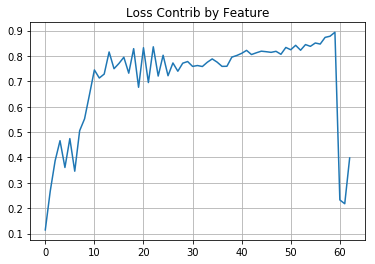

In [25]:
plt.plot(workings['loss_contrib'].sum(axis=(0,1)))
plt.grid(True)
plt.title('Loss Contrib by Feature')
plt.show()

In [26]:
np.sum(workings['loss_contrib'].sum(axis=(0,1)))

44.596706

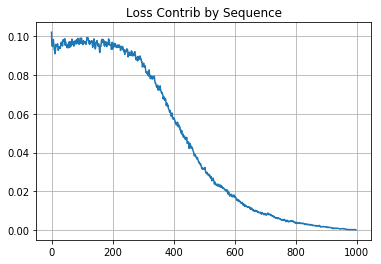

In [27]:
plt.plot(workings['loss_contrib'].sum(axis=(0,2)))
plt.grid(True)
plt.title('Loss Contrib by Sequence')
plt.show()

In [28]:
num_utterances_at_length = [np.sum(workings['target_len'] >= i) for i in range(np.max(workings['target_len']))]
#plt.plot(num_utterances_at_length)

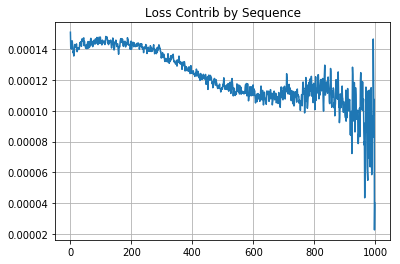

In [29]:
plt.plot(workings['loss_contrib'].sum(axis=(0,2)) 
         / num_utterances_at_length)
plt.grid(True)
plt.title('Loss Contrib by Sequence')
plt.show()

In [30]:
tmp_p = pd.Series(workings['loss_contrib'].sum(axis=(0,2)) / num_utterances_at_length)

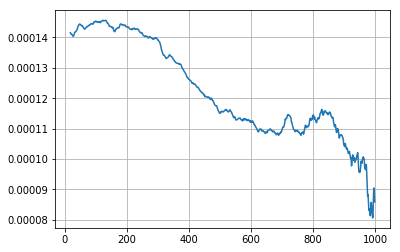

In [31]:
plt.plot(tmp_p.rolling(20).mean())
plt.grid(True)

## Loss by utterance

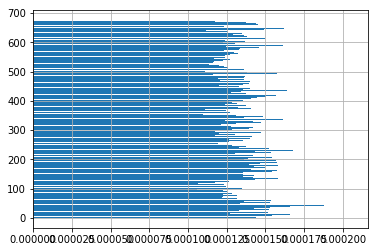

In [32]:
loss_contrib_by_utterance = workings['loss_contrib'].sum(axis=(1,2))
loss_per_unit_length = loss_contrib_by_utterance / workings['target_len']

num_utterance = len(workings['target_len'])
plt.barh(range(num_utterance), loss_per_unit_length)
plt.grid(True)

In [33]:
df = pd.DataFrame(loss_per_unit_length, index=range(num_utterance))

In [34]:
df.sort_values(0, ascending=False).head()

,0
133,0.000206
42,0.000188
622,0.000181
36,0.000177
17,0.000172


In [35]:
df.sort_values(0, ascending=True).head()

,0
365,0.000087
269,0.000097
488,0.000099
468,0.000100
277,0.000101


### Checks on feature distributions

In [36]:
workings = workings_early

In [37]:
# quick check on mean/variance
tf = workings['target_feat']
op = workings['output']
for idx, t in enumerate(workings['target_len']):
    tf[idx, t:, :] = np.nan
    op[idx, t:, :] = np.nan

Text(0.5,1,u'Mean Feature Values')

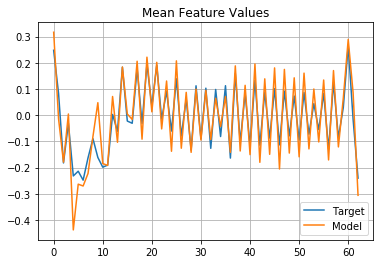

In [38]:
plt.plot(np.nanmean(tf, axis=(0,1)))
plt.plot(np.nanmean(op, axis=(0,1)))
plt.grid(True)
plt.legend(('Target', 'Model'))
plt.title('Mean Feature Values')

Text(0.5,1,u'Std of Feature Values')

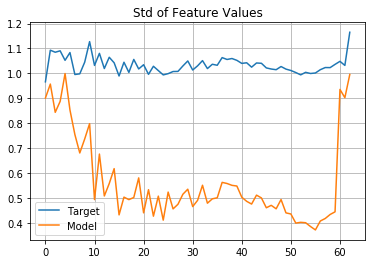

In [39]:
plt.plot(np.nanstd(tf, axis=(0,1)))
plt.plot(np.nanstd(op, axis=(0,1)))
plt.grid(True)
plt.legend(('Target', 'Model'))
plt.title('Std of Feature Values')

In [40]:
#### So VoiceLoop is really struggling to get enough variance in the higher-order mgcs
# Struggling to learn them
# Should we modify the normalisation?
# Or the loss function?
# Or maybe it just doesn't matter?

In [41]:
import scipy.stats as st

In [42]:
# what do the distributions of the features look like? Are they normal?
k = np.zeros(63)
s = np.zeros(63)
v = np.zeros(63)

for i in range(63):
    tmp = tf[:, :, i].flatten()
    tmp[np.isnan(tmp)]
    tmp = np.delete(tmp, np.flatnonzero(np.isnan(tmp)))
    
    v[i] = np.std(tmp)
    s[i] = st.skew(tmp)
    k[i] = st.kurtosis(tmp)

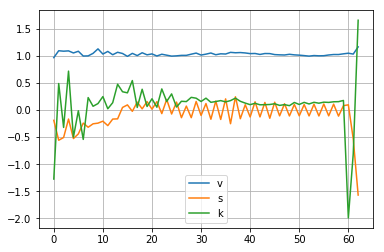

In [43]:
plt.plot(v)
plt.plot(s)
plt.plot(k)
plt.legend(('v', 's', 'k'))
plt.grid(True)
plt.show()

#### Attention

In [44]:
# TODO NEXT: quick look at the attention
plot_attn(attn, txt, NpzFolder(valid_dataset_path).dict)


NameError: name 'attn' is not defined

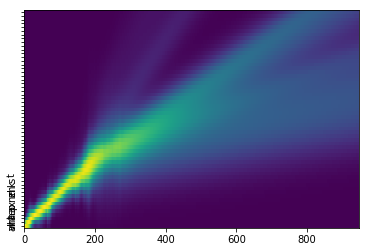

In [45]:
plot_attn(workings['attn'][idx], workings['txt'][idx, :workings['txt_len'][idx]], loader.dataset.dict)

## Loss by Speaker

In [63]:
workings = workings_early

In [64]:
num_spkr = len(np.unique(workings['spkr']))
loss_by_spkr = np.zeros(num_spkr)
loss_by_spkr_norm = np.zeros(num_spkr)

for spkr in np.unique(workings['spkr']):
    idx_this_spkr = np.flatnonzero(workings['spkr'] == spkr)
    loss_by_spkr[spkr] = workings['loss_contrib'][idx_this_spkr, :, :].sum()
    count_by_spkr = workings['target_len'][idx_this_spkr].sum()
    loss_by_spkr_norm[spkr] = loss_by_spkr[spkr] / count_by_spkr

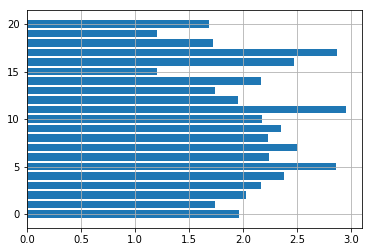

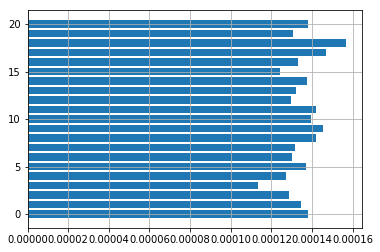

In [65]:
plt.barh(range(num_spkr), loss_by_spkr)
plt.grid(True)
plt.show()

plt.barh(range(num_spkr), loss_by_spkr_norm)
plt.grid(True)
plt.show()

## Checks for a particular utterance

In [70]:
idx = 138 # bad one
#idx = 121 # good one
#idx = 237 # bad one

#idx = 133
#idx = 185
#idx = 365
#idx = 529
#idx = 174
#idx = 181
idx = 55
idx = 195
idx = 617
idx = 313
idx = 271
idx = 80

,id,age,gender,accents,region
334,334,18,M,American,Chicago


Sutton is playing as well as ever today.


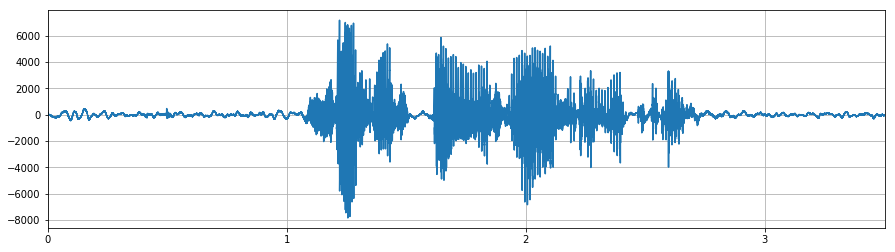

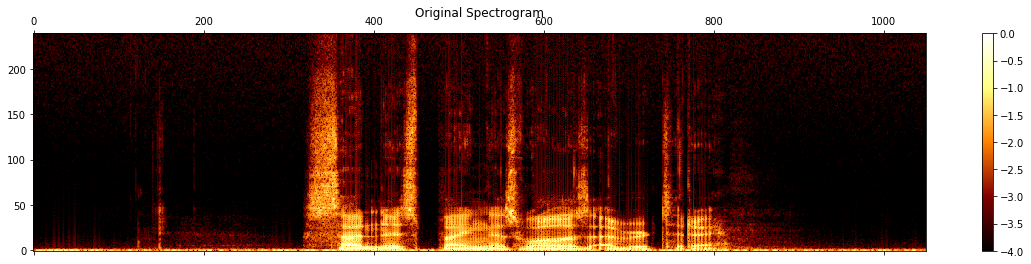

In [71]:
vctk_raw_folder = '/home/ubuntu/VCTK-Corpus/'
vctk_prebuilt_folder = '/home/ubuntu/vctk-16khz-cmu-no-boundaries-us/'
speaker_info = get_vtck_speaker_info()
idx_spkr = int(os.path.basename(npz_map[idx][1]).split('_')[0][1:])
idx_sample = int(os.path.basename(npz_map[idx][1]).split('_')[1][:-4])
display_vctk_sample(idx_spkr, idx_sample)

#### Synthesized from Ground Truth Features

In [72]:
generate_merlin_wav(workings['target_feat'][idx, :workings['target_len'][idx], :],
                    '',
                    'tst',
                    '/home/ubuntu/loop/data/vctk-16khz-cmu-no-boundaries-us/norm_info/norm.dat')

Audio('tst' + '.wav', autoplay=True)

{'mgc': 0, 'vuv': 60, 'lf0': 61, 'bap': 62}
complete tst.wav.


#### Synthesized from Output Features

In [73]:
generate_merlin_wav(workings['output'][idx, :, :],
                    '',
                    'tst',
                    '/home/ubuntu/loop/data/vctk-16khz-cmu-no-boundaries-us/norm_info/norm.dat')

Audio('tst' + '.wav', autoplay=True)

{'mgc': 0, 'vuv': 60, 'lf0': 61, 'bap': 62}
complete tst.wav.


#### Kick out higher-order mgcs...

In [74]:
tmp = copy.deepcopy(workings['output'][idx, :, :])
tmp[:, 20:59] = 0
#tmp[:, 62] = 0
#for i in range(63):
#    tmp[:, i] = tmp[:, i] / np.abs(tmp[:300,i]).mean() * np.abs(workings['target_feat'][idx, :300, i]).mean()
generate_merlin_wav(tmp,
                    '',
                    'tst',
                    '/home/ubuntu/loop/data/vctk/norm_info/norm.dat')

Audio('tst' + '.wav', autoplay=True)

{'mgc': 0, 'vuv': 60, 'lf0': 61, 'bap': 62}
complete tst.wav.


In [75]:
pre_calc_feats = np.load(npz_map[idx][1])

In [76]:
pre_calc_feats['text']

KeyError: 'text is not a file in the archive'

#### Loss Contributions

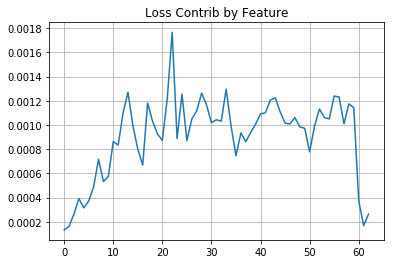

In [77]:
plt.plot(workings['loss_contrib'][idx, :, :].sum(0))
plt.grid(True)
plt.title('Loss Contrib by Feature')
plt.show()

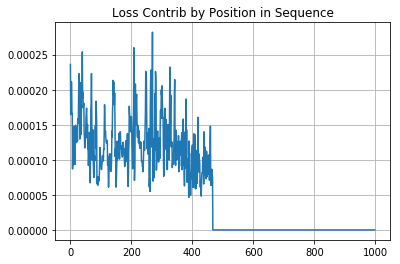

In [78]:
plt.plot(workings['loss_contrib'][idx, :, :].sum(1))
plt.grid(True)
plt.title('Loss Contrib by Position in Sequence')
plt.show()

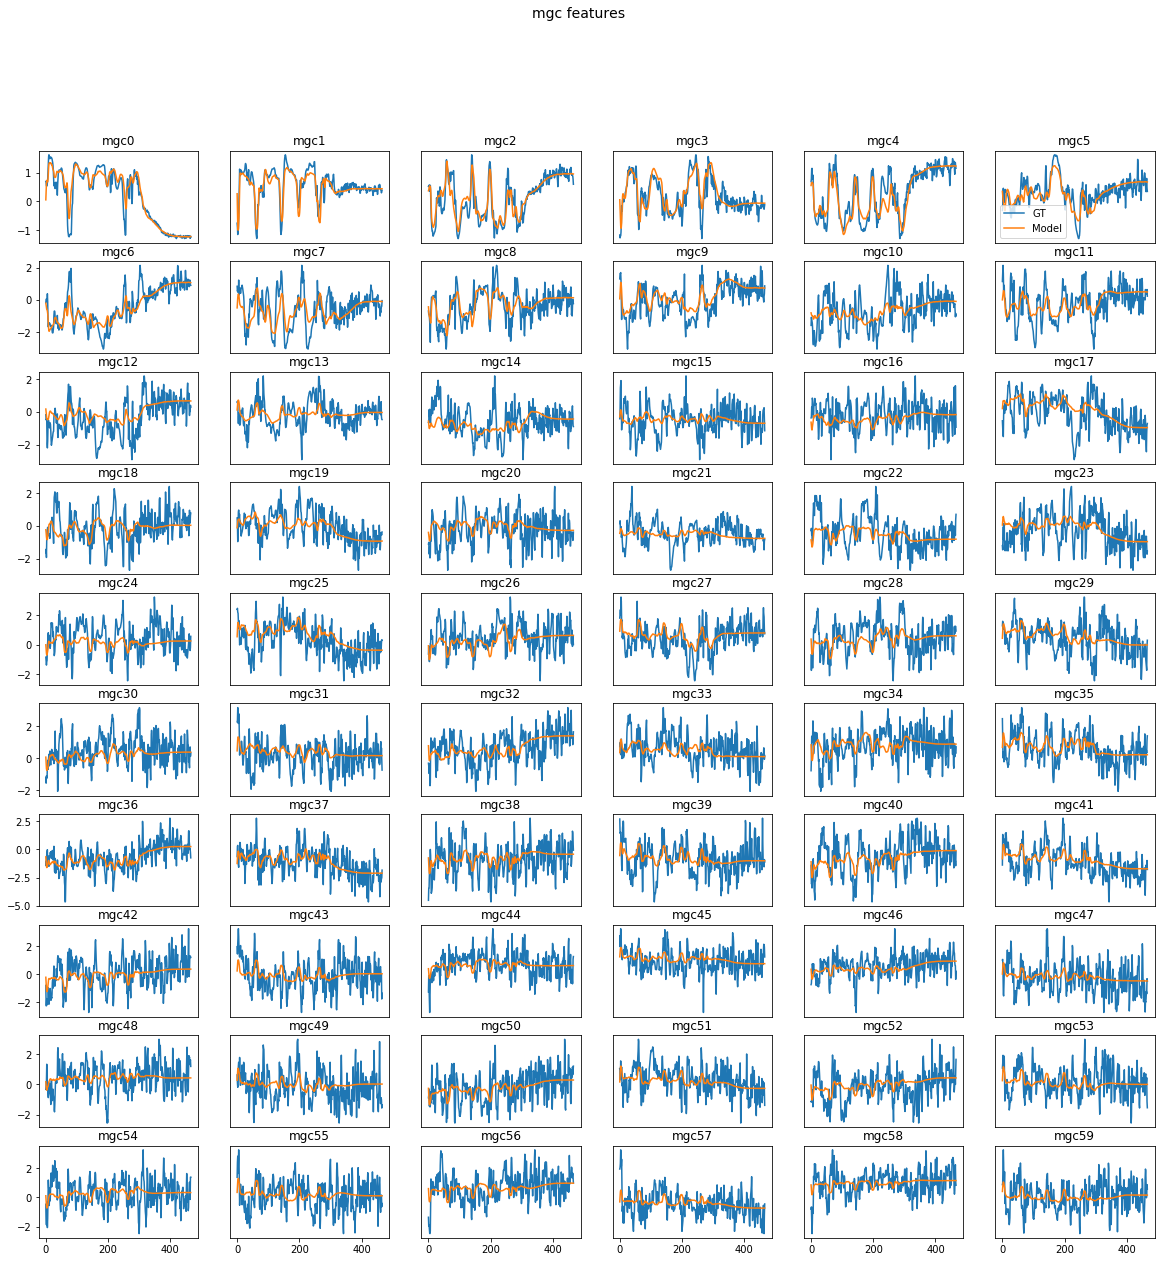

In [79]:
plot_mgc_feature_comparison(workings['target_feat'][idx,:,:], workings['output'][idx,:,:], label_a='GT', label_b='Model')

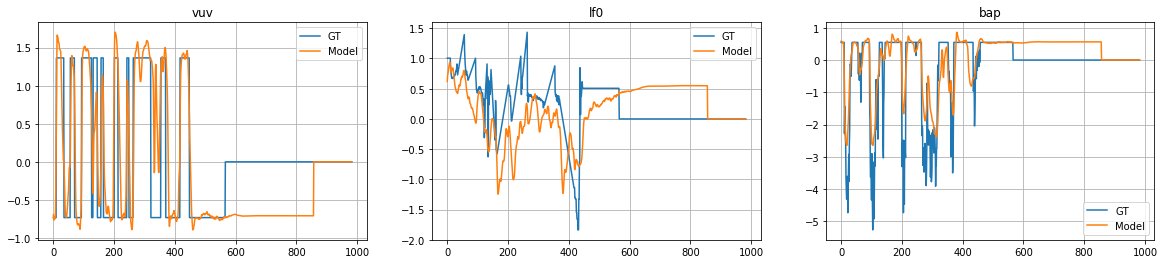

In [78]:
plot_other_feature_comparison(workings['target_feat'][idx,:,:], workings['output'][idx,:,:], label_a='GT', label_b='Model')

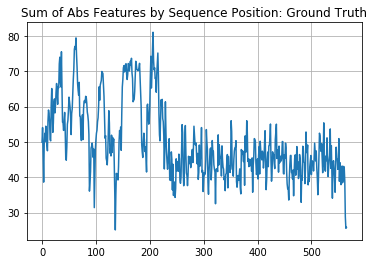

In [13]:
plt.plot(np.abs(workings['target_feat'][idx, :workings['target_len'][idx], :]).sum(1))
plt.grid(True)
plt.title('Sum of Abs Features by Sequence Position: Ground Truth')
plt.show()

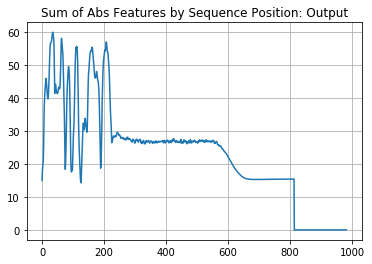

In [14]:
plt.plot(np.abs(workings['output'][idx, :, :]).sum(1))
plt.grid(True)
plt.title('Sum of Abs Features by Sequence Position: Output')
plt.show()

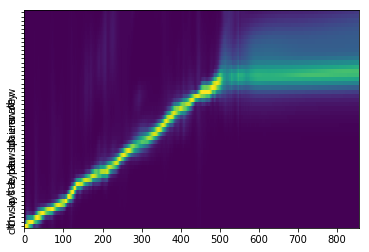

In [81]:
plot_attn(workings['attn'][idx], workings['txt'][idx, :workings['txt_len'][idx]], loader.dataset.dict)

In [112]:
workings = workings_best

# OLD STUFF

In [38]:
workings.keys()

['loss_contrib',
 'spkr',
 'idx_batch',
 'target_len',
 'idx_pos_in_batch',
 'target_feat',
 'txt_len',
 'attn',
 'output',
 'txt']

In [39]:
#workings['spkr'][0]

In [40]:
workings['target_len']

array([767, 713, 574, 516, 730, 536, 530, 530, 408, 493, 602, 433, 414,
       366, 407, 446, 445, 328, 316, 400, 374, 295, 388, 377, 409, 407,
       358, 337, 276, 277, 392, 254, 380, 315, 259, 251, 323, 305, 227,
       416, 311, 269, 280, 334, 310, 321, 225, 261, 212, 198, 254, 215,
       235, 238, 253, 217, 191, 239, 364, 221, 142, 179, 210, 827, 690,
       743, 777, 482, 633, 565, 493, 665, 433, 517, 467, 460, 528, 447,
       390, 510, 420, 448, 450, 496, 375, 344, 318, 364, 380, 349, 305,
       290, 431, 261, 275, 266, 354, 311, 300, 349, 358, 346, 275, 335,
       262, 269, 434, 292, 307, 322, 289, 189, 297, 225, 232, 253, 351,
       367, 369, 201, 247, 179, 191, 135, 153,  93, 767, 791, 723, 485,
       641, 465, 449, 562, 635, 533, 469, 412, 345, 438, 457, 390, 328,
       390, 348, 453, 471, 422, 281, 348, 389, 457, 377, 384, 334, 290,
       284, 303, 296, 386, 251, 324, 260, 412, 344, 380, 232, 289, 241,
       219, 312, 240, 355, 274, 244, 309, 238, 354, 267, 183, 22

In [41]:
workings['target_feat'][1].shape

(979, 63)

In [42]:
loader.dataset.speakers

{'p294': 0,
 'p297': 1,
 'p299': 2,
 'p300': 3,
 'p301': 4,
 'p305': 5,
 'p306': 6,
 'p308': 7,
 'p310': 8,
 'p311': 9,
 'p318': 10,
 'p329': 11,
 'p330': 12,
 'p333': 13,
 'p334': 14,
 'p339': 15,
 'p341': 16,
 'p345': 17,
 'p360': 18,
 'p361': 19,
 'p362': 20}

In [43]:
np.mean([w.sum() for w in workings['loss_contrib']])

0.051919527

In [46]:
w = workings['loss_contrib']

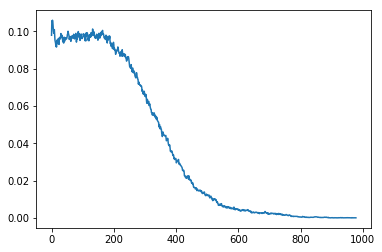

In [47]:
plt.plot(w.sum(axis=(0,2)))

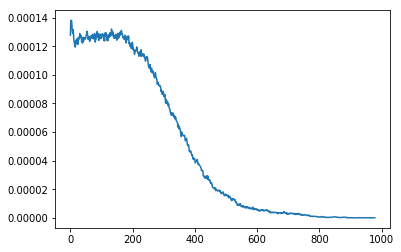

In [48]:
plt.plot(w.sum(axis=(0,2)) / workings['target_len'][0])

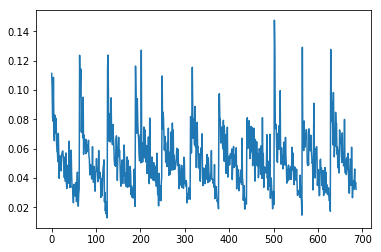

In [49]:
plt.plot(w.sum(axis=(1,2)))

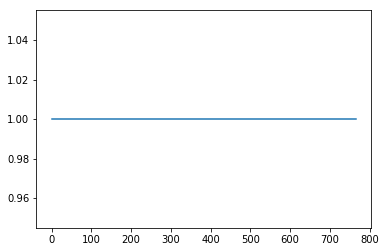

In [50]:
plt.plot([np.sum(workings['target_len'][0] >= i) for i in range(767)])

In [51]:
num_at_len = [np.sum(workings['target_len'][0] >= i) for i in range(767)]

In [52]:
plt.plot(w.sum(axis=(1,2)) / num_at_len)

ValueError: operands could not be broadcast together with shapes (687,) (767,) 

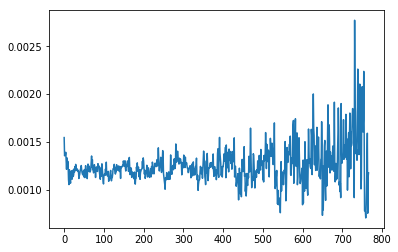

In [233]:
plt.plot(w.sum(axis=(1,2)) / num_at_len)

In [245]:
w = workings['loss_contrib'][2]

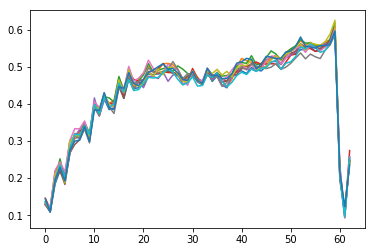

In [247]:
for w in workings['loss_contrib']:
    plt.plot(w.sum(axis=(0,1)))

In [259]:
contrib_by_feat = (np.stack([w.sum(axis=(0,1)) for w in workings['loss_contrib']]).sum(0)/11)

In [261]:
contrib_by_feat.sum()

27.461645

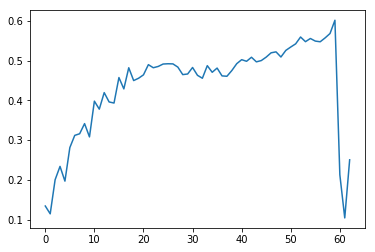

In [273]:
plt.plot(contrib_by_feat)

So it looks like the higher MGC terms have a much bigger contribution to the total loss than vuv, lf0 or bap. Is this okay? Could we get a better result by investigating more carefully?
Make a notebook that allows you to check out the results of a given sample
Therefore need a way to tie each sample in the batch to the original file...

In [140]:
for n in loader.dataset.npzs:
    tmp = loader.dataset.loader(n)
    if tmp == []:
        print 'empty'

In [290]:
attn = workings['attn']

In [293]:
attn[0].shape

(767, 63, 54)

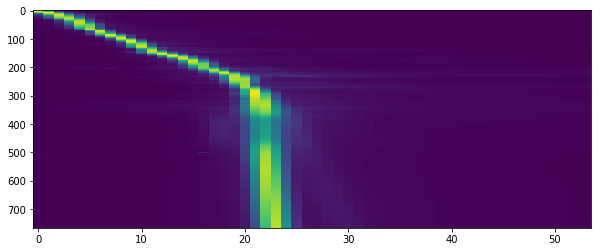

In [308]:
plt.figure(figsize=(10,4))
plt.imshow(attn[0][:, 40, :], aspect='auto')#, origin='lower', interpolation='nearest', cmap=cm.viridis)
#axarr.set_yticks(np.arange(0, len(data.T)))
#axarr.set_yticklabels(labels, rotation=90)

In [4]:
def text2phone(text, char2code):
    seperator = phonemizer.separator.Separator('', '', ' ')
    ph = phonemizer.phonemize(text, separator=seperator)
    ph = ph.split(' ')
    ph.remove('')

    ph = [p.replace('zh', 'jh') for p in ph]

    result = [char2code[p] for p in ph]
    return torch.LongTensor(result)

In [66]:
def trim_pred(out, attn):
    tq = np.abs(attn).sum(1).data

    for stopi in range(1, tq.size(0)):
        col_sum = attn[:stopi, :].abs().sum(0).data.squeeze()

        if type(tq[stopi]) == float:
            if tq[stopi] < 0.5 and col_sum[-1] > 4:
                break
        else:  
            if tq[stopi][0] < 0.5 and col_sum[-1] > 4:
                break

    out = out[:stopi, :]
    attn = attn[:stopi, :]

    return out, attn

In [6]:
def npy_loader_phonemes(path):
    feat = np.load(path)

    txt = feat['phonemes'].astype('int64')
    txt = torch.from_numpy(txt)

    audio = feat['audio_features']
    audio = torch.from_numpy(audio)

    return txt, audio, feat

In [8]:
def generate_sample_with_loop(npz='', text='', spkr_id=1, checkpoint='models/vctk/bestmodel.pth', output_dir = './',
                             npz_path = '/home/ubuntu/loop/data/vctk/numpy_features'):
    #npz = ''
    #text = 'Your tickets for the social issues'
    #text = 'see that girl watch that scene'
    #npz = '/home/ubuntu/loop/data/vctk/numpy_features/p294_011.npz'
    #spkr_id = 12
    #checkpoint = 'checkpoints/vctk/lastmodel.pth'
    #checkpoint = 'models/vctk/bestmodel.pth'
    
    out_dict = dict()
    
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    gpu = 0

    # load loop weights & params from checkpoint
    weights = torch.load(checkpoint,
                         map_location=lambda storage, loc: storage)
    opt = torch.load(os.path.dirname(checkpoint) + '/args.pth')
    train_args = opt[0]

    train_dataset = NpzFolder('/home/ubuntu/loop/data/vctk/numpy_features')
    char2code = train_dataset.dict
    spkr2code = train_dataset.speakers

    norm_path = train_args.data + '/norm_info/norm.dat'
    norm_path = '/home/ubuntu/loop/data/vctk/norm_info/norm.dat'
    train_args.noise = 0
    
    valid_dataset_path = npz_path + '_valid'

    
    # prepare loop model
    model = Loop(train_args)
    model.load_state_dict(weights)
    if gpu >= 0:
        model.cuda()
    model.eval()

    # check speaker id is valid
    if spkr_id not in range(len(spkr2code)):
        print('ERROR: Unknown speaker id: %d.' % spkr_id)

    # get phone sequence
    txt, feat, spkr, output_fname = None, None, None, None
    if npz is not '':
        # use pre-calculated phonemes etc.
        txt, feat, pre_calc_feat = npy_loader_phonemes(os.path.join(npz_path, npz))

        txt = Variable(txt.unsqueeze(1), volatile=True)
        feat = Variable(feat.unsqueeze(1), volatile=True)
        spkr = Variable(torch.LongTensor([spkr_id]), volatile=True)

        output_file = os.path.basename(npz)[:-4]
        
        out_dict['pre_calc_feat'] = pre_calc_feat
        
    elif text is not '':
        # use specified text string
        # extract phonemes from the text
        txt = text2phone(text, char2code)
        feat = torch.FloatTensor(txt.size(0)*20, 63)
        spkr = torch.LongTensor([spkr_id])

        txt = Variable(txt.unsqueeze(1), volatile=True)
        feat = Variable(feat.unsqueeze(1), volatile=True)
        spkr = Variable(spkr, volatile=True)

        output_file = text.replace(' ', '_')
    else:
        print('ERROR: Must supply npz file path or text as source.')
        raise Exception('Need source')

    # use gpu
    if gpu >= 0:
        txt = txt.cuda()
        feat = feat.cuda()
        spkr = spkr.cuda()

    # run loop model to generate output features 
    loop_feat, attn = model([txt, spkr], feat)
    loop_feat, attn = trim_pred(loop_feat, attn)
    
    # add to output dictionary
    out_dict['txt'] = txt[:,0].squeeze().data.tolist()
    out_dict['spkr'] = spkr
    out_dict['feat'] = feat.data.cpu().numpy()
    out_dict['loop_feat'] = loop_feat.data.cpu().numpy()
    out_dict['attn'] = attn.squeeze().data.cpu().numpy()
    out_dict['output_file'] = output_file
    out_dict['valid_dataset_path'] = valid_dataset_path
    


    # generate .wav file from loop output features
    generate_merlin_wav(loop_feat.data.cpu().numpy(),
                        output_dir,
                        output_file,
                        norm_path)
    
    
    # generate .wav file from original features for reference
    if npz is not '':
        output_orig_fname = os.path.basename(npz)[:-4] + '.orig'
        generate_merlin_wav(feat[:, 0, :].data.cpu().numpy(),
                            output_dir,
                            output_orig_fname,
                            norm_path)
        out_dict['output_orig_fname'] = output_orig_fname
    
    return out_dict

In [9]:
'p294' (140094102801024) = {int} 0
'p297' (140094102801312) = {int} 1
'p299' (140094102801888) = {int} 2
'p300' (140094102872208) = {int} 3
'p301' (140094102800880) = {int} 4
'p305' (140094102801072) = {int} 5
'p306' (140094102874032) = {int} 6
'p308' (140094102801600) = {int} 7
'p310' (140094102801648) = {int} 8
'p311' (140094102801168) = {int} 9
'p318' (140094102802272) = {int} 10
'p329' (140094102801984) = {int} 11
'p330' (140094102801408) = {int} 12
'p333' (140094102872352) = {int} 13
'p334' (140094102802320) = {int} 14
'p339' (140094102802128) = {int} 15
'p341' (140094102872928) = {int} 16
'p345' (140094102801216) = {int} 17
'p360' (140094102872304) = {int} 18
'p361' (140094102874944) = {int} 19
'p362' (140094102872448) = {int} 20

SyntaxError: invalid syntax (<ipython-input-9-34a04edd470b>, line 1)

## Generate Code

In [10]:
loop_dict = generate_sample_with_loop(text='testing testing')

{'mgc': 0, 'vuv': 60, 'lf0': 61, 'bap': 62}
complete testing_testing.wav.


In [11]:
loop_dict = generate_sample_with_loop(npz='p308_254.npz', spkr_id=7)

{'mgc': 0, 'vuv': 60, 'lf0': 61, 'bap': 62}
complete p308_254.wav.
{'mgc': 0, 'vuv': 60, 'lf0': 61, 'bap': 62}
complete p308_254.orig.wav.


In [15]:
Audio(loop_dict['output_file'] + '.wav', autoplay=True)

In [17]:
Audio(loop_dict['output_orig_fname'] + '.wav', autoplay=True)

In [222]:
loop_dict.keys()

['output_orig_fname',
 'spkr',
 'output_file',
 'pre_calc_feat',
 'loop_feat',
 'valid_dataset_path',
 'attn',
 'txt',
 'feat']

In [223]:
for key,val in loop_dict.items():
    exec(key + '=val')

In [224]:
attn.shape
# (n_output_features, n_phones_in_text)

(219, 15)

In [225]:
pre_calc_feat.keys()

['vuv_idx',
 'audio_norminfo',
 'lf0_idx',
 'code2char',
 'text_features',
 'text',
 'durations',
 'audio_features',
 'code2phone',
 'mgc_extent',
 'bap_idx',
 'file_id',
 'phonemes',
 'text_norminfo']

In [226]:
pre_calc_feat['audio_features'].shape

(220, 63)

In [227]:
pre_calc_feat

In [228]:
pre_calc_feat['phonemes'].shape

(15,)

In [229]:
print pre_calc_feat['text']

We are at a crossroads.


In [230]:
print " ".join(pre_calc_feat['code2phone'][pre_calc_feat['phonemes']])

w iy aa r ae t ax k r ao s r ow d z


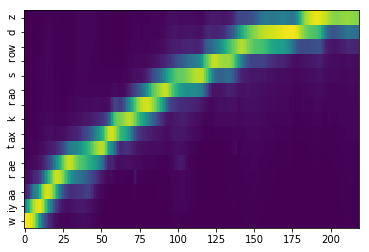

In [231]:
plot_attn(attn, txt, NpzFolder(valid_dataset_path).dict)

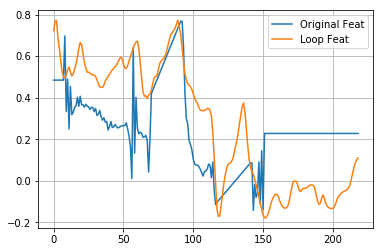

In [238]:
idx_feat = 61
plt.plot(feat[:-idx_end, 0, idx_feat])
plt.plot(loop_feat[:, 0, idx_feat])
plt.grid(True)
plt.legend(('Original Feat', 'Loop Feat'))
plt.show()

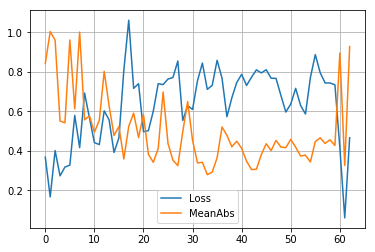

In [239]:
plt.plot(np.square(loop_feat - feat[:-idx_end,:,:]).squeeze().mean(0))
plt.plot(np.mean(np.abs(loop_feat.squeeze()), 0))
plt.grid(True)
plt.legend(('Loss', 'MeanAbs'))

In [240]:
np.square(loop_feat - feat[:-idx_end,:,:]).squeeze().sum() / loop_feat.shape[0]

39.95064569063927

In [241]:
np.mean(np.abs(loop_feat), 0)

array([[ 0.842489  ,  1.00477552,  0.96043956,  0.55105639,  0.54187679,
         0.96183193,  0.61203611,  1.00166619,  0.55707693,  0.57708937,
         0.49464461,  0.55385554,  0.80298418,  0.62669247,  0.47761589,
         0.523597  ,  0.35855764,  0.52438205,  0.59119898,  0.46705166,
         0.58346224,  0.38289273,  0.34179643,  0.41127279,  0.69781584,
         0.43677768,  0.35266012,  0.32480869,  0.49694747,  0.64949894,
         0.45263425,  0.33891329,  0.34184283,  0.27935848,  0.29205516,
         0.36470005,  0.52089405,  0.47847936,  0.42044961,  0.44867203,
         0.41210654,  0.34741107,  0.30521438,  0.30636764,  0.38055992,
         0.43587384,  0.40106311,  0.45270544,  0.41877523,  0.41615254,
         0.45837229,  0.41836566,  0.37391049,  0.37794563,  0.34342614,
         0.44713476,  0.46576571,  0.43746328,  0.45579344,  0.42726162,
         0.8960399 ,  0.32576901,  0.92828971]], dtype=float32)

TODO:
    try smoothing the feature timeseries, see how the output sounds

# Other Investigations

## Loader: Why more files than elements in batch?
1) How to map the batch elements back to the original files?
2) Why are 13 entries getting dropped?

In [78]:
loader = el.get_loader()

In [79]:
len(loader.dataset.npzs)

700

In [80]:
np.hstack(workings['target_len']).shape

(729,)

why are there 687 entries but 700 in the dataset? Turns out that max_seq_len = 1000, so all longer utterances are getting dropped. Also the batches are sorted by decreasing length, so there's no immediately way to link the batch elements back to the original samples.

First: loader.dataset[file_id] has 3 elements:

1) Phoneme code sequence 17

2) WORLD features (ground truth) 232x63

3) Speaker ID (scalar)

In [693]:
loader.dataset[100][2]

11

In [694]:
loader.dataset.npzs[699]

'data/vctk/numpy_features_valid/p311_349.npz'

#### Manually link batch elements back to the original samples

In [61]:
workings['txt'][3][:, 10]

array([16, 19,  9, 18,  9, 16, 18, 41,  7, 11, 31, 34, 29,  7,  2, 34, 18,
       34, 39,  0, 41, 24, 34, 15, 36,  9, 18, 24,  2, 14,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])

In [569]:
d = {b: a for a, b in loader.dataset.dict.iteritems()}

In [74]:
d[workings['txt'][3][:, 10]]


TypeError: unhashable type: 'numpy.ndarray'

In [70]:
workings.keys()

['loss_contrib',
 'spkr',
 'idx_batch',
 'target_len',
 'idx_pos_in_batch',
 'target_feat',
 'txt_len',
 'attn',
 'output',
 'txt']

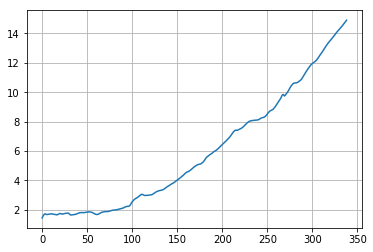

In [339]:
# Modify LF0
hack_feat = copy.deepcopy(out.data.cpu().numpy())
hack_feat[:, 0, 61] += np.square(np.linspace(0,4,hack_feat.shape[0]))
plt.plot(hack_feat[:, 0, 61])
plt.grid(True)

output_file_hack = output_file + '_hack'

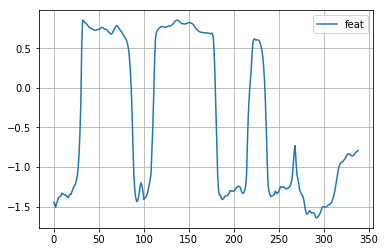

In [303]:
# Visualise VUV
np_feat = feat.data.cpu().numpy()
np_out = out.data.cpu().numpy()
#plt.plot(np_feat[:, 0, 61])
plt.plot(np_out[:, 0, 60])
plt.grid(True)
plt.legend(['feat', 'out'])

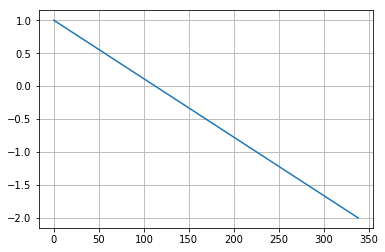

In [304]:
# Modify VUV
hack_feat = copy.deepcopy(out.data.cpu().numpy())
hack_feat[:, 0, 60] = np.linspace(1,-2,hack_feat.shape[0])
plt.plot(hack_feat[:, 0, 60])
plt.grid(True)

output_file_hack = output_file + '_hack'

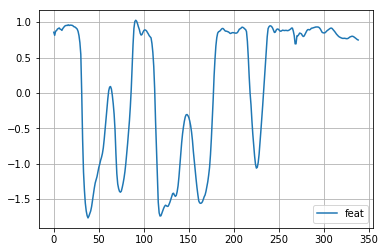

In [179]:
# Visualise BAP
np_feat = feat.data.cpu().numpy()
np_out = out.data.cpu().numpy()
#plt.plot(np_feat[:, 0, 61])
plt.plot(np_out[:, 0, 62])
plt.grid(True)
plt.legend(['feat', 'out'])

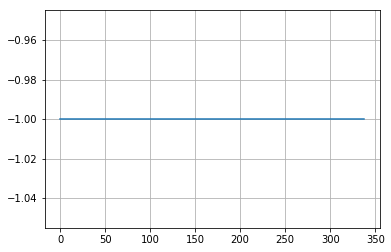

In [186]:
# Modify BAP
hack_feat = copy.deepcopy(out.data.cpu().numpy())
hack_feat[:, 0, 62] = -1# np.linspace(1,-2,hack_feat.shape[0])
plt.plot(hack_feat[:, 0, 62])
plt.grid(True)

output_file_hack = output_file + '_hack'

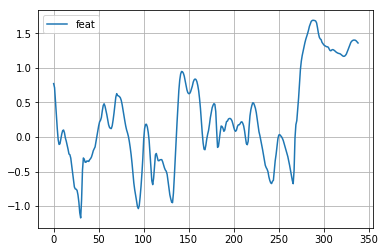

In [277]:
# Visualise MGC0
idx_mgc = 10
np_feat = feat.data.cpu().numpy()
np_out = out.data.cpu().numpy()
plt.plot(np_out[:, 0, idx_mgc])
plt.grid(True)
plt.legend(['feat', 'out'])

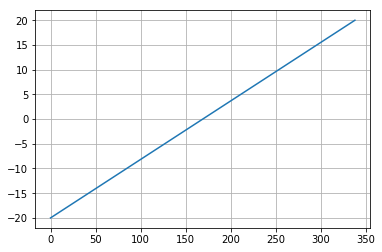

In [278]:
# Modify MGC0
hack_feat = copy.deepcopy(out.data.cpu().numpy())
hack_feat[:, 0, idx_mgc] = np.linspace(-20,+20,hack_feat.shape[0])
plt.plot(hack_feat[:, 0, idx_mgc])
plt.grid(True)

output_file_hack = output_file + '_hack'

#### Generate .wav file from hacked features

In [340]:
generate_merlin_wav(hack_feat[:, 0, :],
                    output_dir,
                    output_file_hack,
                    norm_path)

Audio(output_file_hack + '.wav', autoplay=True)

{'mgc': 0, 'vuv': 60, 'lf0': 61, 'bap': 62}
complete see_that_girl_watch_that_scene_hack.wav.


In [280]:
hack_feat.shape

(339, 1, 63)

In [281]:
# TODO
# .wav file visualisation
# spectrogram?
# use pydub?
# look at normalisation of the features?
# can I get MSE out?

## Spectrograms

In [341]:
import spectrogram as sp

# iPython specific stuff
%matplotlib inline
import IPython.display
from ipywidgets import interact, interactive, fixed

# Packages we're using
from scipy.io import wavfile
from scipy.signal import butter, lfilter
import scipy.ndimage

In [342]:
### Parameters ###
fft_size = 480# 2048 # window size for the FFT
#step_size = int(fft_size/16) # distance to slide along the window (in time)
step_size = 160 # distance to slide along the window (in time)
spec_thresh = 4 # threshold for spectrograms (lower filters out more noise)
lowcut = 500 # Hz # Low cut for our butter bandpass filter
highcut = 7500 #15000 # Hz # High cut for our butter bandpass filter

# For mels
n_mel_freq_components = 40# 64 # number of mel frequency channels
shorten_factor = 1#10 # how much should we compress the x-axis (time)
start_freq = 300 # Hz # What frequency to start sampling our melS from 
end_freq = 8000 # Hz # What frequency to stop sampling our melS from

In [343]:
output_file

'see_that_girl_watch_that_scene'

In [344]:
# This is a nice, clean possum sample
mywav = output_file + '.wav'
mywav_hack = output_file_hack + '.wav'

rate, data = wavfile.read(mywav)
data = sp.butter_bandpass_filter(data, lowcut, highcut, rate, order=1)
#data = butter_bandpass_filter(data, 500, 7500, rate, order=1)
# Only use a short clip for our demo
if np.shape(data)[0]/float(rate) > 10:
    data = data[0:rate*10] 
print('Length in time (s):' + str(np.shape(data)[0]/float(rate)))

rate, data_hack = wavfile.read(mywav_hack)
data_hack = sp.butter_bandpass_filter(data_hack, lowcut, highcut, rate, order=1)

Length in time (s):1.6900625


In [345]:
# Play the audio
IPython.display.Audio(data=data, rate=rate, autoplay=True)

In [346]:
IPython.display.Audio(data=data_hack, rate=rate, autoplay=True)

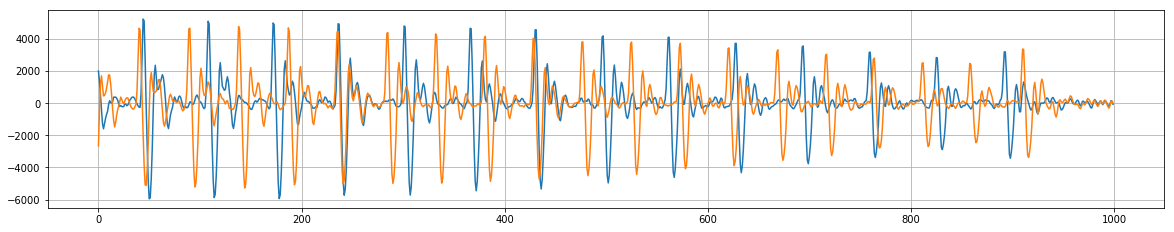

In [347]:
# Plot raw sound data
idx_start = 6000
idx_end = 7000
plt.figure(figsize=[20,8])

plt.subplot(2,1,1)
plt.plot(data[idx_start:idx_end])
#plt.grid()

#plt.subplot(2,1,2)
plt.plot(data_hack[idx_start:idx_end])
plt.grid()

In [348]:
#plt.plot(data_hack - data)

In [349]:
wav_spectrogram = sp.pretty_spectrogram(data.astype('float64'), fft_size = fft_size, 
                                   step_size = step_size, log = True, thresh = spec_thresh)

wav_spectrogram_hack = sp.pretty_spectrogram(data_hack.astype('float64'), fft_size = fft_size, 
                                   step_size = step_size, log = True, thresh = spec_thresh)

Text(0.5,1.05,u'Difference')

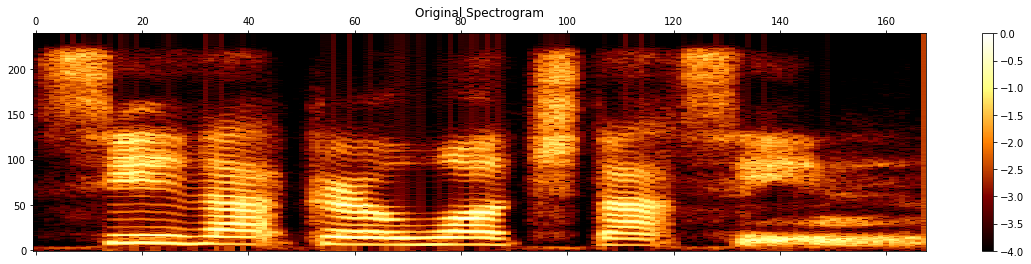

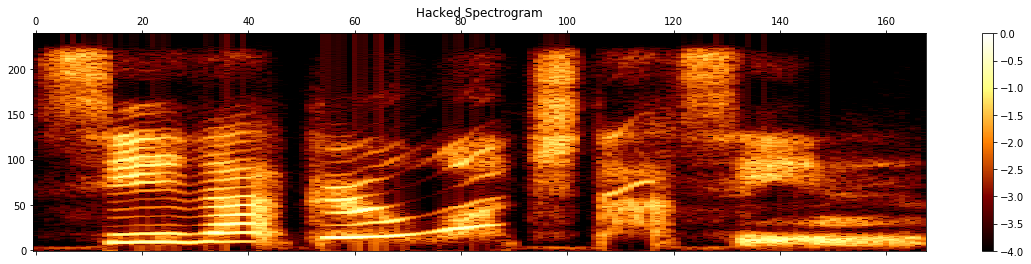

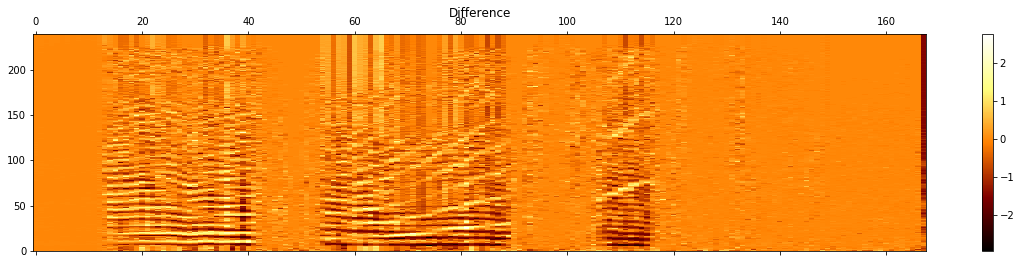

In [350]:
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(20,4))
cax = ax.matshow(np.transpose(wav_spectrogram), interpolation='nearest', aspect='auto', cmap=plt.cm.afmhot, origin='lower')
fig.colorbar(cax)
plt.title('Original Spectrogram')

fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(20,4))
cax = ax.matshow(np.transpose(wav_spectrogram_hack), interpolation='nearest', aspect='auto', cmap=plt.cm.afmhot, origin='lower')
fig.colorbar(cax)
plt.title('Hacked Spectrogram')

fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(20,4))
cax = ax.matshow(np.transpose(wav_spectrogram_hack - wav_spectrogram), interpolation='nearest', aspect='auto', cmap=plt.cm.afmhot, origin='lower')
fig.colorbar(cax)
plt.title('Difference')

In [336]:
print np.mean(np.square(wav_spectrogram))
print np.mean(np.square(wav_spectrogram_hack - wav_spectrogram))

9.36202110683
0.149842307785


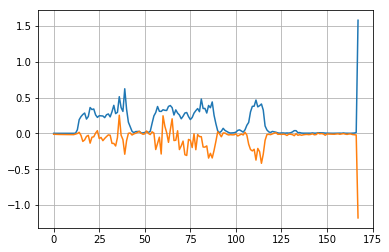

In [338]:
x = wav_spectrogram_hack - wav_spectrogram
plt.plot(np.mean(np.square(x), 1))
plt.grid(True)
plt.plot(np.mean(x, 1))
plt.grid(True)

### Mel Spectrograms

In [294]:
# Generate the mel filters
mel_filter, mel_inversion_filter = sp.create_mel_filter(fft_size = fft_size,
                                                        n_freq_components = n_mel_freq_components,
                                                        start_freq = start_freq,
                                                        end_freq = end_freq, samplerate=16000) # may need to change sample rate

Text(0.5,1.05,u'mel Inversion Filter')

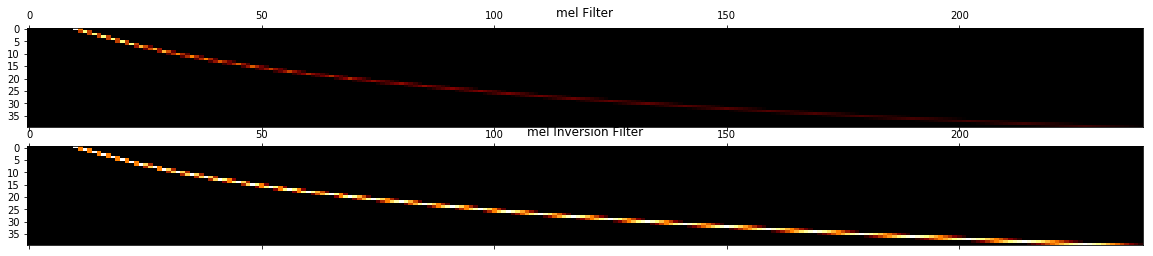

In [295]:
# take a look at both of the filters
fig, ax = plt.subplots(nrows=2,ncols=1, figsize=(20,4))
ax[0].matshow(np.transpose(mel_filter),cmap=plt.cm.afmhot, interpolation='nearest', aspect='auto')
ax[0].set_title('mel Filter')
ax[1].matshow(mel_inversion_filter,cmap=plt.cm.afmhot, interpolation='nearest', aspect='auto')
ax[1].set_title('mel Inversion Filter')

In [296]:
mel_spec = sp.make_mel(wav_spectrogram, mel_filter, shorten_factor = shorten_factor)
mel_spec_hack = sp.make_mel(wav_spectrogram_hack, mel_filter, shorten_factor = shorten_factor)

Text(0.5,1.05,u'Difference')

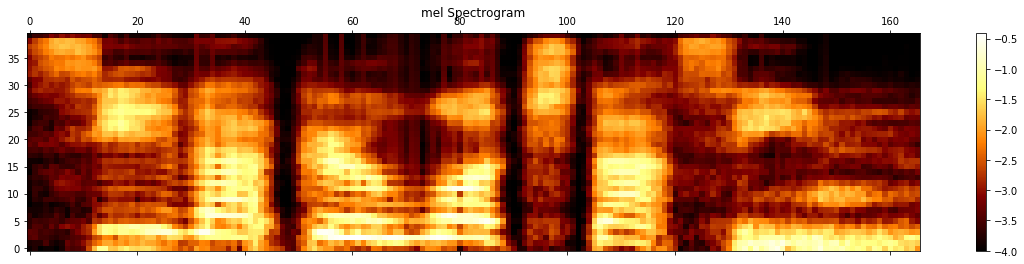

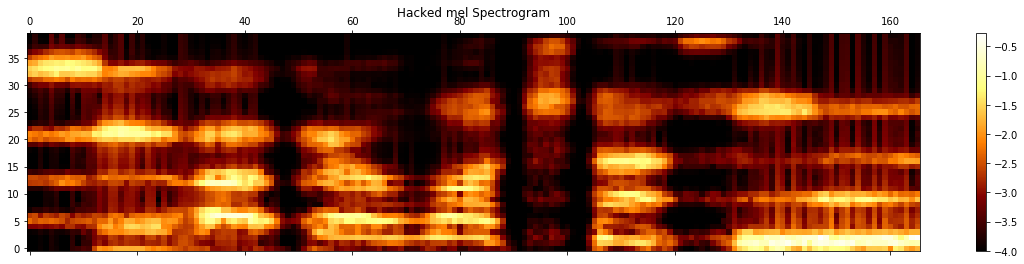

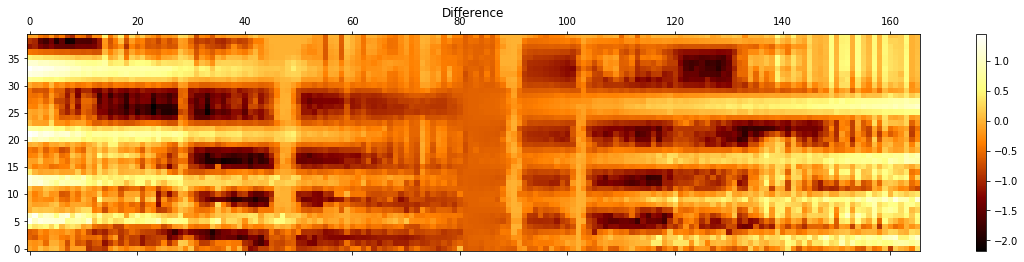

In [297]:
# plot the compressed spec
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(20,4))

cax = ax.matshow(np.float64(mel_spec), interpolation='nearest', aspect='auto', cmap=plt.cm.afmhot, origin='lower')
fig.colorbar(cax)
plt.title('mel Spectrogram')

# plot the compressed spec
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(20,4))

cax = ax.matshow(np.float64(mel_spec_hack), interpolation='nearest', aspect='auto', cmap=plt.cm.afmhot, origin='lower')
fig.colorbar(cax)
plt.title('Hacked mel Spectrogram')

fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(20,4))

cax = ax.matshow(np.float64(mel_spec_hack - mel_spec), interpolation='nearest', aspect='auto', cmap=plt.cm.afmhot, origin='lower')
fig.colorbar(cax)
plt.title('Difference')

In [300]:
print np.mean(np.square(mel_spec))
print np.mean(np.square(mel_spec_hack - mel_spec))

8.1484
0.44263


### Spectrogram Inversion etc.

In [267]:
# Output some stats of our file
print(''.join(['mel Spectrogram Size: ',str(np.shape(mel_spec))]))
print(''.join(['Original Spectrogram Size: ',str(np.shape(np.transpose(wav_spectrogram)))]))
print(''.join(['Original Waveform Size: ',str(np.shape(data))]))
print(''.join(['Length (s): ', str(len(data)/float(rate))]))
print(''.join(['Original Sampling Rate (ms) : ', str(1./float(rate))]))
print(''.join(['New Sampling Rate (ms): ', str(float(np.shape(mel_spec)[1]) / (len(data)/float(rate)))]))

mel Spectrogram Size: (40, 166)
Original Spectrogram Size: (240, 168)
Original Waveform Size: (27041,)
Length (s): 1.6900625
Original Sampling Rate (ms) : 6.25e-05
New Sampling Rate (ms): 98.2212196295


In [268]:
mel_inverted_spectrogram = sp.mel_to_spectrogram(mel_spec, mel_inversion_filter,
                                                spec_thresh=spec_thresh,
                                                shorten_factor=shorten_factor)

Text(0.5,1.05,u'Inverted mel Spectrogram')

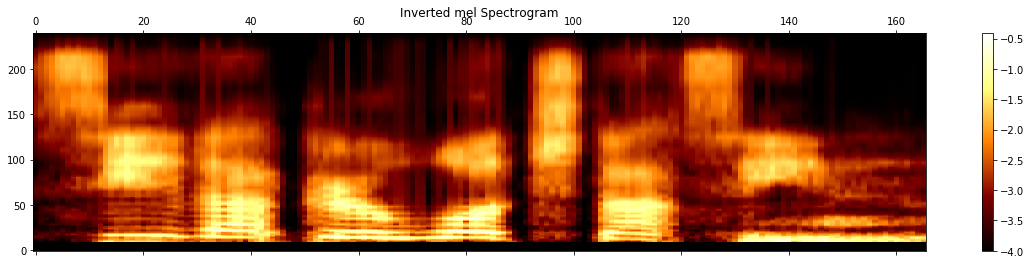

In [269]:
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(20,4))
cax = ax.matshow(np.float64(mel_inverted_spectrogram), cmap=plt.cm.afmhot, origin='lower', aspect='auto',interpolation='nearest')
fig.colorbar(cax)
plt.title('Inverted mel Spectrogram')

In [270]:
inverted_mel_audio = sp.invert_pretty_spectrogram(np.transpose(mel_inverted_spectrogram), fft_size = fft_size,
                                            step_size = step_size, log = True, n_iter = 10)
IPython.display.Audio(data=inverted_mel_audio, rate=rate)

ValueError: operands could not be broadcast together with shapes (166,480) (165,480) 